# Load pifpaf data
Inconveniently, pifpaf outputs one json object per frame, resulting in a .json file per a scene consisting of N_frame lines of separate json objects.  
You cannot read the whole file in one go, but need to interpret each line as a json object. 

In [2]:
# hide
%load_ext autoreload
%autoreload 2

import numpy as np
import json
import matplotlib.pyplot as plt 
from numpy.lib.recfunctions import unstructured_to_structured
import BBS_pp_utils as bbpp

In [3]:
data_dir = '/home/hoseung/Dropbox/DeepInsight/2021ETRI/BBS_data/Preds/a/'

fn = data_dir + "a_001_L_11_4.json"

얼굴을 대표하는 값이 하나는 필요함. 코/ 눈/ 귀 중 가장 안정적인 것은?  
**코**는 좌우 영향이 없는 대신 마스크에 가릴 수가 있고, 
**귀**는 좌-우가 있지만 고개를 숙이거나 마스크를 써도 가리지 않음. 

일단 코를 써보기로

## PifPaf output

.json 파일은 nframe개의 json object로 구성되어있고, 각 object의 prediction은 (x1,y1,p1,x2,y2,p2,...,x_n_key, y_n_key, p_n_key), p는 측정의 정확도, n_key는 keypoint의 개수)로 이루어짐.  

Object별 전체 정확도를 계산하고 criterion을 넘기는 경우에만 보존. 
얼굴은 하나의 포인트로 표현할 것이므로 불필요한 keypoint 제거.


In [4]:
base_dir = "/home/hoseung/Work/data/BBS/g1/"

def fn_to_fn_img(fn, cnt):
    base_dir = "/home/hoseung/Work/data/BBS/g1/"
    json_name = fn.split("/")[-1]
    
    cam, num, a, action, score = json_name.split("_")
    score = score.replace(".json", "")
    
    fn_img = base_dir + f'{cam}/{num}/BBS/RGB/{a}/{action}/{score}/'
    return fn_img+f"{cnt:04d}.jpg"

In [5]:
from glob import glob 
fn_list = glob(data_dir+"*/*.json")
fn_list.sort()

In [6]:
dtypes = bbpp.get_dtypes(ignored_joints=[])
inds_store, ind_confidence = bbpp.get_inds_to_store(dtypes, return_confidence=True)
print("storing (frame count+)", len(inds_store), "points ")

storing (frame count+) 34 points 


## 8번: 앞으로 굽혀서 손 뻗기

In [7]:
get_class = lambda fn : int(fn.split("_")[-2])
get_cam   = lambda fn : fn.split("_")[-5][-1]

In [8]:
class8 = [ fn for fn in fn_list if get_class(fn) == 8]
class8.sort()
class8a = [ fn for fn in class8 if get_cam(fn) == "a"]


In [9]:
len(class8a)

410

In [10]:
from BBS_pp_utils import json_to_arr

In [13]:
fn = class8a[4]
arrs = json_to_arr(fn, dtypes)

FileNotFoundError: [Errno 2] No such file or directory: '/home/hoseung/Work/data/BBS/g1/a/004/BBS/RGB/L/8/1/0590.jpg'

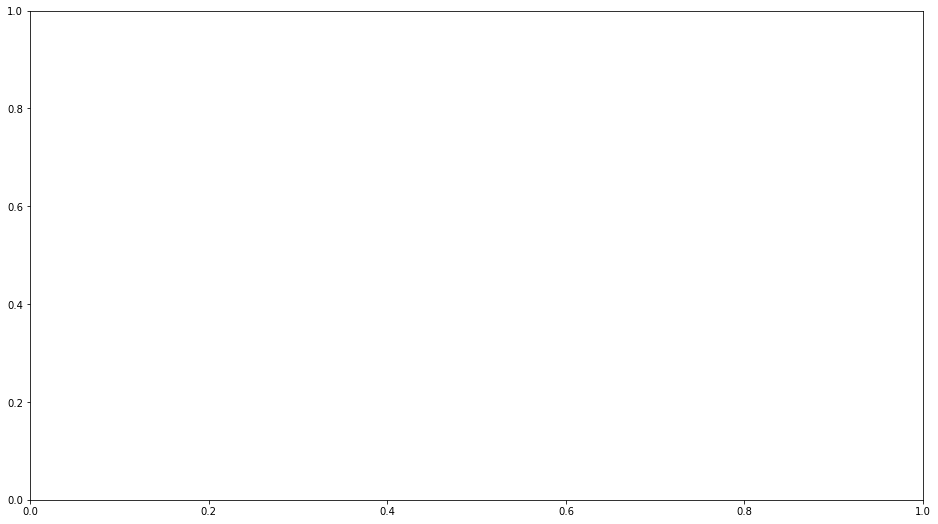

In [14]:
plt.close("all")
#def draw_anno(fn, arrs, frames):
fig, ax = plt.subplots(figsize=(16,9))

im = plt.imread(fn_to_fn_img(fn, 590))

ax.imshow(im,zorder=1)

for arr in arrs:
    arr = arr[590:600]
    ax.scatter(arr["xnose"], arr["ynose"], zorder=2, c=arr['frame'], s=3)#, cmap="viridis")
    #ax.scatter(arr["xright_knee"], arr["yright_knee"], zorder=2, c=arr['frame'], s=3, cmap="viridis")
    #ax.scatter(arr["xright_hip"], arr["yright_hip"], zorder=2, c=arr['frame'], s=3, cmap="jet")
    #ax.scatter(arr["xright_wrist"], arr["yright_wrist"], zorder=2, c=arr['frame'], s=3, cmap="jet")
ax.set_xlim([600,800])
ax.set_ylim([400,200])
plt.show()

In [15]:
# Draw_skeleton
arms_points_x = ['xleft_wrist', 'xleft_elbow', 'xleft_shoulder', 'xright_shoulder','xright_elbow', 'xright_wrist']
arms_points_y=['y'+aax[1:] for aax in arms_points_x]

# Side view

완전 옆에서 볼 경우 반대편 몸은 측정 안되는 부분이 많음. 
-- 보이는 쪽 데이터만 있어도 충분 할 듯. 

In [23]:
arr = arrs[0]

side = bbpp.mean_side(arr)

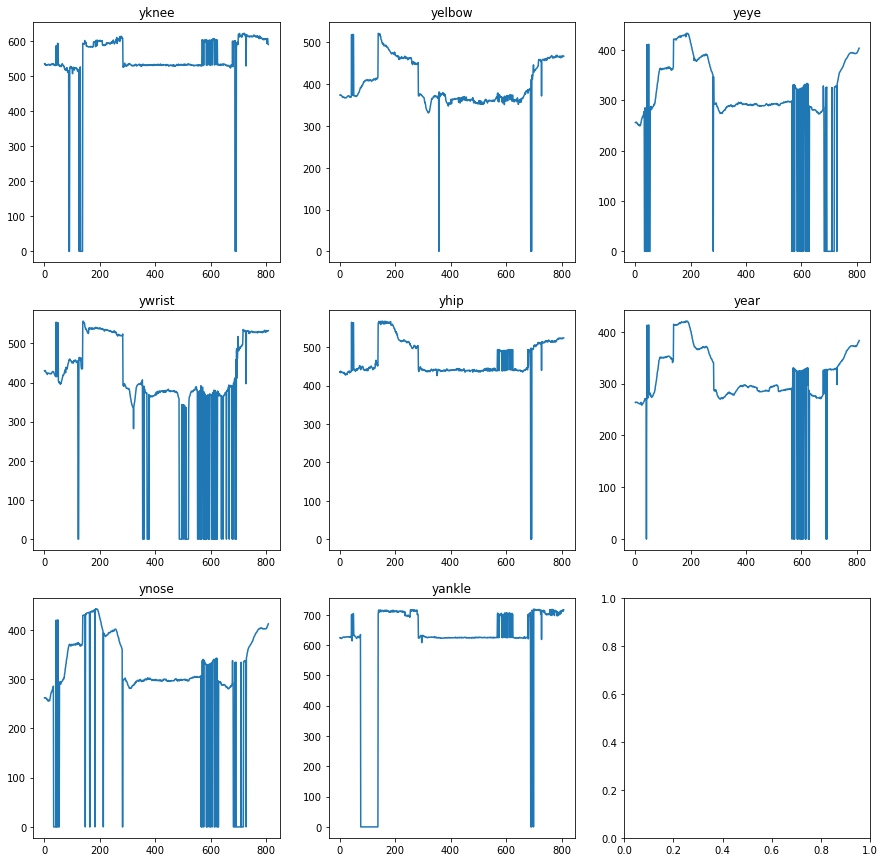

In [24]:
fig, axs = plt.subplots(3,3, figsize=(15,15))
axs=axs.ravel()

i=0
for dt in side.dtype.names[1:]:
    if dt.startswith("y"):
        axs[i].plot(side['frame'], side[dt])
        axs[i].set_title(dt)
        i+=1

In [19]:
mean_dtypes=[]
for nn in arr.dtype.names:
    dt = arr.dtype[nn]
    nn=nn.replace("left_",'')
    nn=nn.replace("right_",'')
    
    mean_dtypes.append((nn,dt))

set(mean_dtypes)

NameError: name 'arr' is not defined

In [132]:
ll = list(set(mean_dtypes))

In [134]:
ll.sort()

In [135]:
ll

[('frame', dtype('int64')),
 ('xankle', dtype('float64')),
 ('xear', dtype('float64')),
 ('xelbow', dtype('float64')),
 ('xeye', dtype('float64')),
 ('xhip', dtype('float64')),
 ('xknee', dtype('float64')),
 ('xnose', dtype('float64')),
 ('xshoulder', dtype('float64')),
 ('xwrist', dtype('float64')),
 ('yankle', dtype('float64')),
 ('year', dtype('float64')),
 ('yelbow', dtype('float64')),
 ('yeye', dtype('float64')),
 ('yhip', dtype('float64')),
 ('yknee', dtype('float64')),
 ('ynose', dtype('float64')),
 ('yshoulder', dtype('float64')),
 ('ywrist', dtype('float64'))]

In [125]:
arr.dtype['frame']

dtype('int64')

4

In [156]:
def plot_all_feature(arr):
    names = [nn for nn in arr.dtype.names if nn.startswith('y') ]
    nx = np.ceil(np.sqrt(len(names))).astype(int)
    
    fig, axs = plt.subplots(nx,nx, figsize=(nx*4,nx*4))
    axs=axs.ravel()

    i=0
    for dt in names:
        axs[i].plot(side['frame'], side[dt])
        axs[i].set_title(dt)
        i+=1

    plt.show()

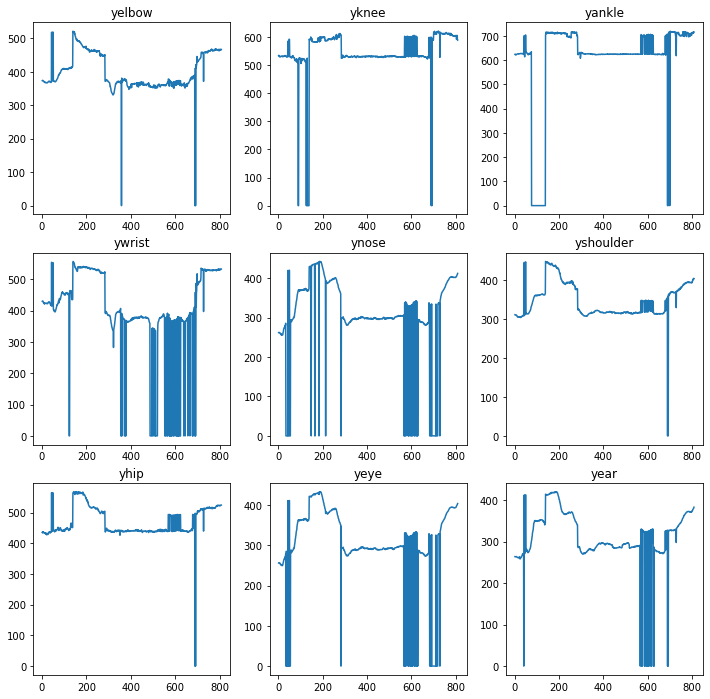

In [157]:
plot_all_feature(side)

In [165]:
arr2[0]['yleft_eye']

array([255.73, 255.01, 255.24, 255.14, 256.87, 256.44, 253.75, 253.35,
       252.04, 250.84, 251.31, 249.82, 249.33, 250.32, 249.89, 248.7 ,
       248.57, 248.12, 248.76, 249.36, 253.59, 254.85, 259.67, 262.31,
       263.68, 266.3 , 266.87, 267.3 , 270.13, 271.3 , 271.18, 273.92,
       278.67,   0.  ,   0.  , 285.45,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  , 411.21,   0.  ,   0.  ,   0.  ,   0.  , 411.32,
       411.42, 411.18,   0.  ,   0.  ,   0.  ,   0.  , 283.82, 286.93,
       285.41, 287.27, 281.17, 283.71, 285.18, 285.25, 285.73, 286.42,
       287.82, 288.1 , 289.65, 292.79, 292.67, 291.79, 295.35, 295.73,
       302.07, 304.79, 308.64, 315.22, 317.68, 323.24, 325.32, 332.34,
       335.49, 338.87, 340.32, 348.47, 352.1 , 355.72, 357.72, 359.92,
       362.  , 364.12, 362.77, 364.84, 362.78, 364.54, 364.32, 362.8 ,
       364.27, 364.86, 364.77, 363.94, 364.13, 364.31, 363.75, 364.69,
       365.29, 365.55, 365.13, 365.92, 366.22, 366.11, 366.13, 365.39,
      

In [166]:
arr2[1]['yleft_eye']

array([  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
      

In [159]:
side[init_skip::20]["year"]

array([273.225, 274.04 , 283.17 , 282.03 , 296.28 , 295.79 , 295.06 ,
       286.765, 285.335, 285.435, 295.47 , 285.21 , 287.34 , 288.75 ,
       324.55 , 325.36 , 330.18 , 276.37 , 273.04 , 280.26 , 327.7  ,
       328.34 , 341.61 , 359.96 , 373.04 , 375.17 ])

In [158]:
side[init_skip::20]["ynose"]

array([288.78, 288.66, 297.23, 297.73, 302.16, 299.56, 298.29, 296.56,
       296.91, 296.42, 299.24, 297.88, 305.06, 304.76, 331.01, 331.81,
       343.02, 288.7 , 281.25, 292.71,   0.  , 336.99, 367.47, 390.48,
       403.37, 403.73])

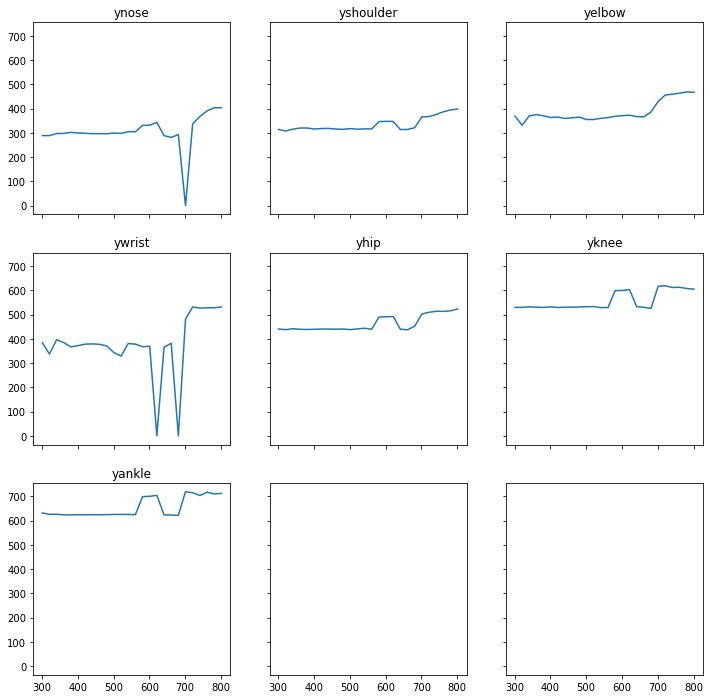

In [95]:
fig, axs = plt.subplots(3,3, figsize=(12,12), sharex=True, sharey=True)
axs=axs.ravel()

i=0
for dt in side.dtype.names[1:]:
    if dt.startswith('y'):
        axs[i].plot(side[init_skip::20]['frame'], 
                    side[init_skip::20][dt])
        axs[i].set_title(dt)
        i+=1

# Nose보다 눈 귀가 더 잘 잡힐까???

# Draw (only available) Joints 
PifPaf도 별 다른거 없음. joint끼리 연결을 설정하고 line을 그음. 대신 add_collection으로

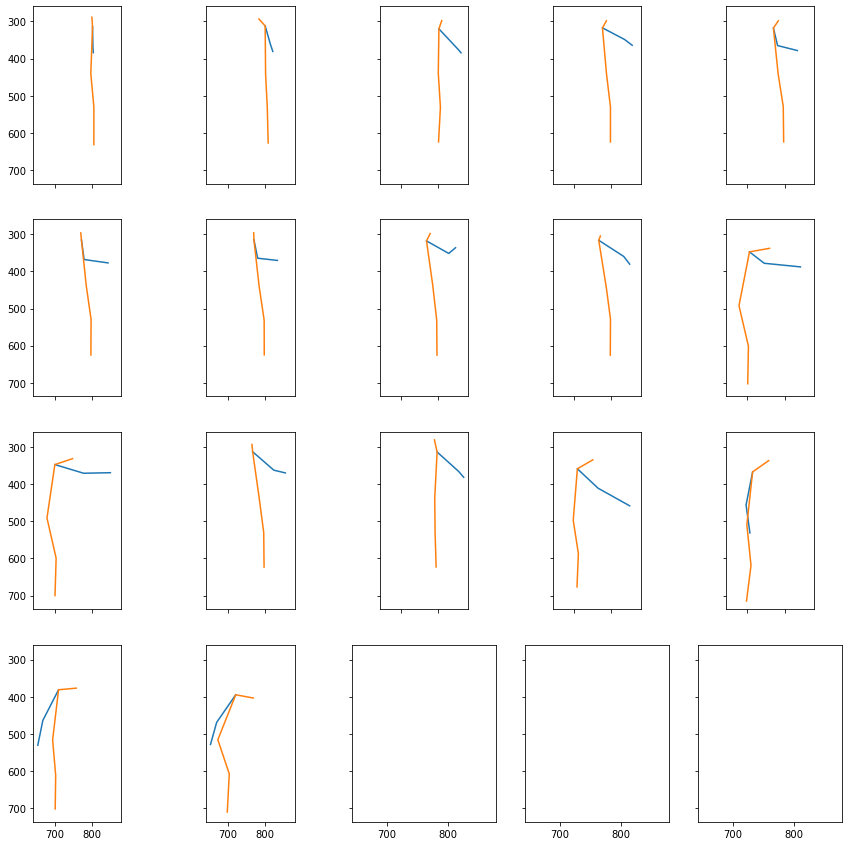

In [25]:
# side 
side_h2t = ['nose','shoulder','hip','knee', 'ankle']
side_arms = ['shoulder', 'elbow', 'wrist']

fig, axs = plt.subplots(4,5, sharex=True, sharey=True)
fig.set_size_inches(15,15)
axs = axs.ravel()

init_skip = 300

for i, ar in enumerate(side[init_skip::30]):
    ax = axs[i]
    ax.plot([ar['x'+sa] for sa in side_arms],
            [ar['y'+sa] for sa in side_arms])

    ax.plot([ar['x'+sa] for sa in side_h2t],
            [ar['y'+sa] for sa in side_h2t])

    ax.set_aspect("equal")
    ax.invert_yaxis()

#plt.show()

8번 중요 변수 : (x 손 - x 엉덩이) / 몸통 길이 

발이 고정 되어있어야함. 

## 빠진 부분 interpolate

In [ ]:
fig, axs = plt.subplots()

In [31]:
arrs[0]

array([(  1, 814.3 , 262.08, 822.77, 312.29, 746.37, 310.17, 839.4 , 370.75, 732.83, 376.53, 847.81, 423.39, 737.39, 435.98, 820.93, 435.66, 768.66, 434.75, 819.42, 532.13, 776.55, 536.03, 812.23, 621.43, 779.2 , 626.36),
       (  2, 813.36, 261.61, 822.03, 311.78, 745.55, 309.85, 839.08, 371.95, 732.95, 376.09, 848.78, 425.98, 738.5 , 434.56, 819.92, 434.32, 767.97, 432.56, 819.09, 530.76, 775.55, 535.9 , 811.45, 620.1 , 779.22, 625.37),
       (  3, 811.21, 262.48, 820.63, 311.56, 743.87, 309.78, 838.46, 373.23, 732.72, 375.86, 849.2 , 427.83, 741.12, 434.05, 819.1 , 438.49, 766.18, 436.42, 820.07, 532.16, 775.15, 537.34, 812.34, 621.29, 779.04, 625.75),
       (  4, 809.6 , 262.4 , 819.38, 311.19, 742.49, 310.08, 836.85, 373.06, 732.42, 374.64, 846.94, 427.99, 745.62, 431.6 , 819.14, 437.71, 764.55, 436.42, 823.24, 530.62, 774.86, 534.73, 812.72, 620.53, 779.14, 625.19),
       (  5, 808.98, 262.43, 818.62, 310.75, 741.29, 311.  , 836.72, 372.6 , 732.4 , 374.5 , 844.88, 426.24, 748

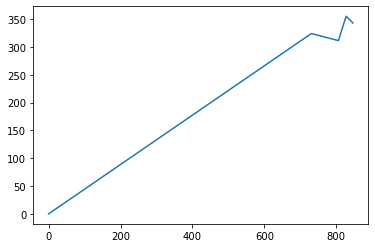

In [30]:
fig, ax = plt.subplots()
ar = arrs[0][500]
ax.plot([ar[aax] for aax in arms_points_x],
        [ar[aay] for aay in arms_points_y])
plt.show()

측정이 안 되는 경우 
1. 측면에서 볼 때 양팔 중 한 팔만 잡힘 (심지어 뒤에 있는 왼쪽팔로 인식 됨) 
(501, 776.01, 299.24, 805.54, 311.34, 730.21, 323.97, 827.03, 355.08, 0., 0., 845.84, 343.07, 0., 0., 812.05, 435.34, 757.94, 440.75, 816.86, 531.3, 775.01, 533.43, 813.35, 624.42, 779.64, 626.58)
-> 좌 = 우로 가정 (0 이상의 평균값 사용) 

In [16]:
arr = arrs[1]

In [34]:
plt.scatter(side['xshoulder'], side['yshoulder'], cmap='jet')
plt.show()

SyntaxError: invalid syntax (144417097.py, line 1)

In [ ]:
mean = np.mean()

In [115]:
missing

array([ 42,  47,  48,  49, 143, 144, 145, 146, 147, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 210, 234, 373, 375, 506, 507,
       527, 558, 559, 565, 568, 569, 570, 571, 572, 573, 575, 576, 577,
       578, 579, 580, 581, 582, 583, 585, 588, 589, 590, 591, 592, 594,
       595, 596, 599, 600, 602, 603, 604, 606, 607, 608, 609, 610, 611,
       612, 613, 614, 615, 616, 617, 618, 619, 620, 622, 623, 624, 625,
       626, 627, 631, 637, 638, 640, 642, 643, 644, 646, 683, 684, 685,
       686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698,
       699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711,
       712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724,
       725, 726, 727, 728, 729, 731, 732, 733, 737])

중간중간에 0이 너무 많은데.. 

In [87]:
ar.dtype

dtype([('frame', '<i8'), ('xnose', '<f8'), ('ynose', '<f8'), ('xleft_shoulder', '<f8'), ('yleft_shoulder', '<f8'), ('xright_shoulder', '<f8'), ('yright_shoulder', '<f8'), ('xleft_elbow', '<f8'), ('yleft_elbow', '<f8'), ('xright_elbow', '<f8'), ('yright_elbow', '<f8'), ('xleft_wrist', '<f8'), ('yleft_wrist', '<f8'), ('xright_wrist', '<f8'), ('yright_wrist', '<f8'), ('xleft_hip', '<f8'), ('yleft_hip', '<f8'), ('xright_hip', '<f8'), ('yright_hip', '<f8'), ('xleft_knee', '<f8'), ('yleft_knee', '<f8'), ('xright_knee', '<f8'), ('yright_knee', '<f8'), ('xleft_ankle', '<f8'), ('yleft_ankle', '<f8'), ('xright_ankle', '<f8'), ('yright_ankle', '<f8')])

In [ ]:
arms_x = [ar['xleft_wrist'],ar['xleft_elbow'], ar['xleft_shoulder'], 
 ar['xright_shoulder'], ar['xright_elbow'], ar['xright_wrist']]
arms_y = [aa]

ax.plot()

In [30]:
arrs[2][590:600]

array([(591, 777.7 , 303.12, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.),
       (592, 777.94, 304.3 , 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.),
       (593, 777.58, 304.83, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.),
       (594, 777.5 , 304.98, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.),
       (595, 777.5 , 304.89, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.),
       (596, 777.82, 305.84, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.),
       (  0,   0.  ,   0.  , 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.),
       (598, 777.38, 306.63, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [20]:
len(arrs)

3

In [89]:
arr.dtype

dtype([('frame', '<i8'), ('xnose', '<f8'), ('ynose', '<f8'), ('xleft_shoulder', '<f8'), ('yleft_shoulder', '<f8'), ('xright_shoulder', '<f8'), ('yright_shoulder', '<f8'), ('xleft_elbow', '<f8'), ('yleft_elbow', '<f8'), ('xright_elbow', '<f8'), ('yright_elbow', '<f8'), ('xleft_wrist', '<f8'), ('yleft_wrist', '<f8'), ('xright_wrist', '<f8'), ('yright_wrist', '<f8'), ('xleft_hip', '<f8'), ('yleft_hip', '<f8'), ('xright_hip', '<f8'), ('yright_hip', '<f8'), ('xleft_knee', '<f8'), ('yleft_knee', '<f8'), ('xright_knee', '<f8'), ('yright_knee', '<f8'), ('xleft_ankle', '<f8'), ('yleft_ankle', '<f8'), ('xright_ankle', '<f8'), ('yright_ankle', '<f8')])

In [115]:
sk = arrs[0][0]

In [123]:
sk = np.array([814.3, 262.08, 822.77, 312.29, 746.37, 310.17, 839.4, 370.75, 732.83, 376.53, 847.81, 423.39, 737.39, 435.98, 820.93, 435.66, 768.66, 434.75, 819.42, 532.13, 776.55, 536.03, 812.23, 621.43, 779.2, 626.36])


In [124]:
sk = sk.reshape(-1,2)

In [125]:
sk

array([[814.3 , 262.08],
       [822.77, 312.29],
       [746.37, 310.17],
       [839.4 , 370.75],
       [732.83, 376.53],
       [847.81, 423.39],
       [737.39, 435.98],
       [820.93, 435.66],
       [768.66, 434.75],
       [819.42, 532.13],
       [776.55, 536.03],
       [812.23, 621.43],
       [779.2 , 626.36]])

In [122]:
sk.T

array([[814.3 , 822.77, 746.37, 839.4 , 732.83, 847.81, 737.39, 820.93,
        768.66, 819.42, 776.55, 812.23, 779.2 ],
       [262.08, 312.29, 310.17, 370.75, 376.53, 423.39, 435.98, 435.66,
        434.75, 532.13, 536.03, 621.43, 626.36]])

In [116]:
sk

(1, 814.3, 262.08, 822.77, 312.29, 746.37, 310.17, 839.4, 370.75, 732.83, 376.53, 847.81, 423.39, 737.39, 435.98, 820.93, 435.66, 768.66, 434.75, 819.42, 532.13, 776.55, 536.03, 812.23, 621.43, 779.2, 626.36)

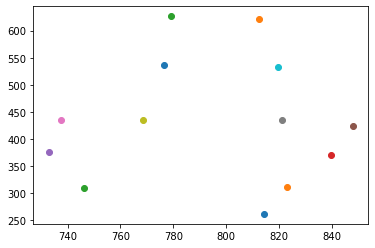

In [112]:
arr = arrs[0]

for i in range(13):
    plt.scatter(arr[0][i*2+1], arr[0][i*2+2])
plt.show()

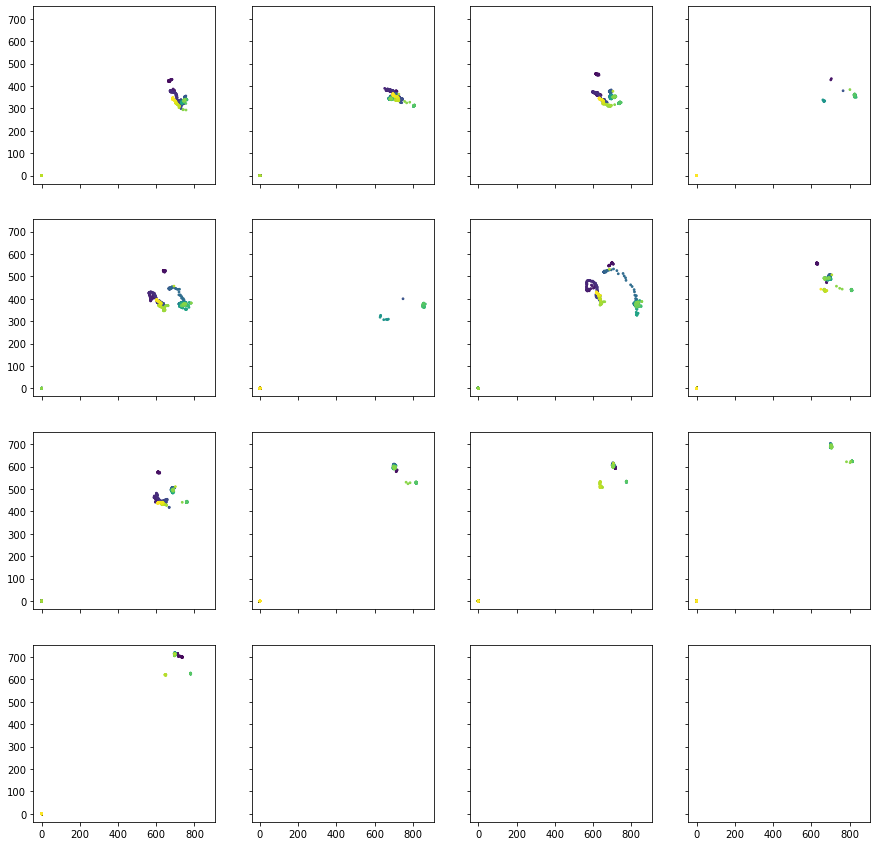

In [35]:
fig, axs = plt.subplots(4,4, sharex=True, sharey=True)
fig.set_size_inches(15,15)
axs = axs.ravel()

arr = arrs[1][100:]
dtypes = arr.dtype
for i in range(13):
    kx = dtypes.names[2*i+1]
    ky = dtypes.names[2*i+2]
    axs[i].scatter(arr[kx], arr[ky], c=arr['frame'], s=3, cmap="viridis")
    
plt.show()

In [40]:
fn

'/home/hoseung/Dropbox/DeepInsight/2021ETRI/BBS_data/Preds/a_004_L_8_1.json'

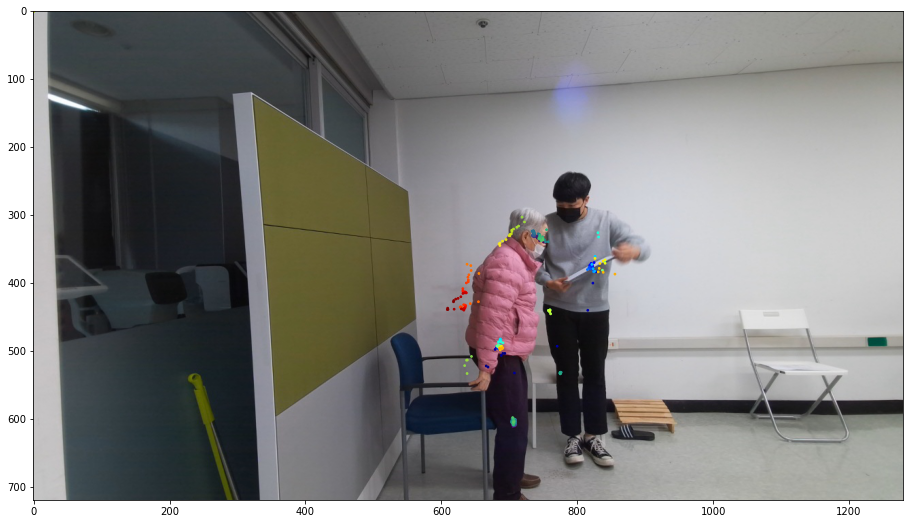

In [73]:
fig, ax = plt.subplots()
fig.set_size_inches(16,9)
im = plt.imread(fn_to_fn_img(fn, 330))
ax.imshow(im,zorder=1)


arr = arrs[1][330::5]
ax.scatter(arr["xnose"], arr["ynose"], zorder=2, c=arr['frame'], s=3, cmap="viridis")
ax.scatter(arr["xright_knee"], arr["yright_knee"], zorder=2, c=arr['frame'], s=3, cmap="viridis")
ax.scatter(arr["xright_hip"], arr["yright_hip"], zorder=2, c=arr['frame'], s=3, cmap="jet")
ax.scatter(arr["xright_wrist"], arr["yright_wrist"], zorder=2, c=arr['frame'], s=3, cmap="jet")
plt.show()

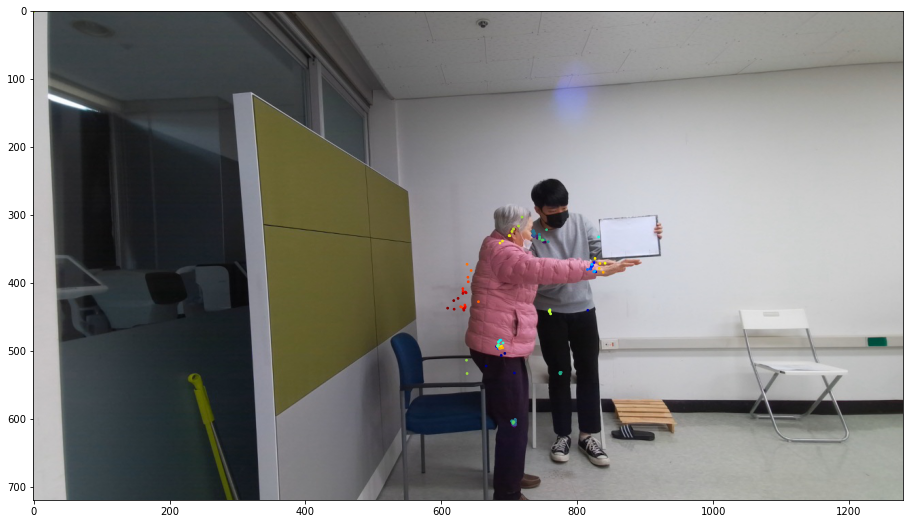

In [75]:
fig, ax = plt.subplots()
fig.set_size_inches(16,9)
im = plt.imread(fn_to_fn_img(fn, 430))
ax.imshow(im,zorder=1)


arr = arrs[1][330::10]
ax.scatter(arr["xnose"], arr["ynose"], zorder=2, c=arr['frame'], s=3, cmap="viridis")
ax.scatter(arr["xright_knee"], arr["yright_knee"], zorder=2, c=arr['frame'], s=3, cmap="viridis")
ax.scatter(arr["xright_hip"], arr["yright_hip"], zorder=2, c=arr['frame'], s=3, cmap="jet")
ax.scatter(arr["xright_wrist"], arr["yright_wrist"], zorder=2, c=arr['frame'], s=3, cmap="jet")
plt.show()

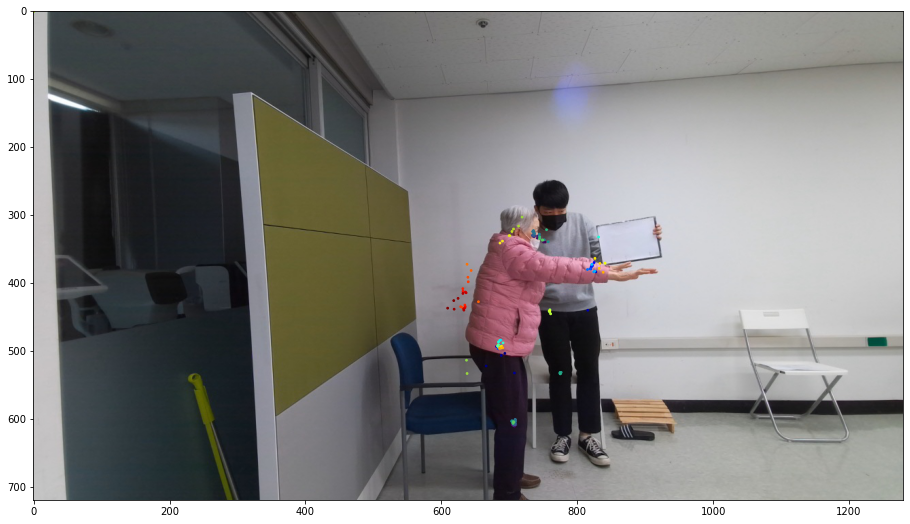

In [76]:
fig, ax = plt.subplots()
fig.set_size_inches(16,9)
im = plt.imread(fn_to_fn_img(fn, 540))
ax.imshow(im,zorder=1)


arr = arrs[1][330::10]
ax.scatter(arr["xnose"], arr["ynose"], zorder=2, c=arr['frame'], s=3, cmap="viridis")
ax.scatter(arr["xright_knee"], arr["yright_knee"], zorder=2, c=arr['frame'], s=3, cmap="viridis")
ax.scatter(arr["xright_hip"], arr["yright_hip"], zorder=2, c=arr['frame'], s=3, cmap="jet")
ax.scatter(arr["xright_wrist"], arr["yright_wrist"], zorder=2, c=arr['frame'], s=3, cmap="jet")
plt.show()

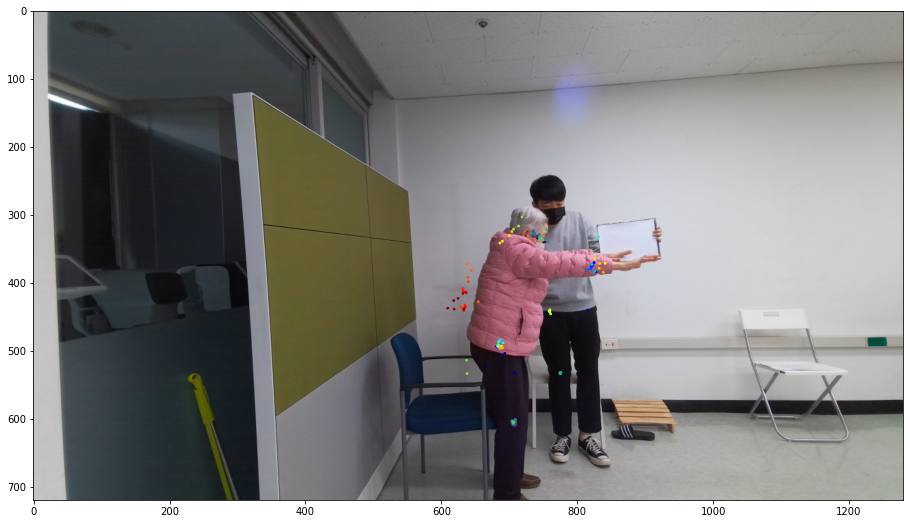

In [79]:
fig, ax = plt.subplots()
fig.set_size_inches(16,9)
im = plt.imread(fn_to_fn_img(fn, 630))
ax.imshow(im,zorder=1)


arr = arrs[1][330::10]
ax.scatter(arr["xnose"], arr["ynose"], zorder=2, c=arr['frame'], s=3, cmap="viridis")
ax.scatter(arr["xright_knee"], arr["yright_knee"], zorder=2, c=arr['frame'], s=3, cmap="viridis")
ax.scatter(arr["xright_hip"], arr["yright_hip"], zorder=2, c=arr['frame'], s=3, cmap="jet")
ax.scatter(arr["xright_wrist"], arr["yright_wrist"], zorder=2, c=arr['frame'], s=3, cmap="jet")
plt.show()

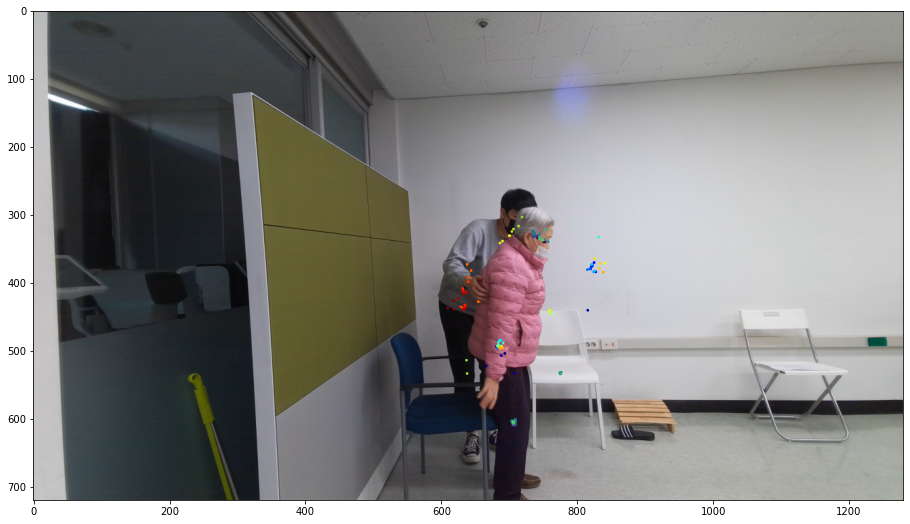

In [80]:
fig, ax = plt.subplots()
fig.set_size_inches(16,9)
im = plt.imread(fn_to_fn_img(fn, 730))
ax.imshow(im,zorder=1)


arr = arrs[1][330::10]
ax.scatter(arr["xnose"], arr["ynose"], zorder=2, c=arr['frame'], s=3, cmap="viridis")
ax.scatter(arr["xright_knee"], arr["yright_knee"], zorder=2, c=arr['frame'], s=3, cmap="viridis")
ax.scatter(arr["xright_hip"], arr["yright_hip"], zorder=2, c=arr['frame'], s=3, cmap="jet")
ax.scatter(arr["xright_wrist"], arr["yright_wrist"], zorder=2, c=arr['frame'], s=3, cmap="jet")
plt.show()

In [ ]:
import sklearn
import sklearn.model_selection
import pickle

X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(data, 
                                                                            l_encode, 
                                                                            test_size=0.15, 
                                                                            stratify=l_encode)

pickle.dump((X_test, Y_test, label_map), open("NTU_testset.pickle", "wb"))
pickle.dump((X_train, Y_train, label_map), open("NTU_trainset.pickle", "wb"))

In [23]:
fn

'/home/hoseung/Dropbox/DeepInsight/2021ETRI/BBS_data/Preds/a_001_L_11_4.json'

아덴티티 바뀜.. ㅠㅠ 

하지만 이전보다 훨씬 정확한 스켈레톤을 얻었으니 fix_jump를 쓰면 잘 해결될 지도. 

## 동영상으로 체크

In [85]:
import json
import logging
import os

from openpifpaf import decoder, logger, network, show, visualizer, __version__
from openpifpaf.predictor import Predictor
from openpifpaf.stream import Stream
import time
LOG = logging.getLogger(__name__)

In [86]:
class dummy():
    def __init__(self):
        pass
args = dummy()

#for i_f, fn in enumerate(fnlist):
args.separate_debug_ax=False
args.debug_indices=None
args.batch_size=4
args.decoder_workers=4

#out_dir = '/home/hoseung/Dropbox/DeepInsight/2021ETRI/BBS_data/Preds/'
out_dir = './'
glob_str = "./g1/a/3??/BBS/RGB/*/*/*"
done=[]

fnlist = [fn for fn in glob(glob_str) if fn not in done]
fnlist.sort()

#for fn in fnlist:
if True:
    fn = '/home/hoseung/Work/data/BBS/g1/a/004/BBS/RGB/L/8/1'
    _,cam, num, _, _, char, action, score=fn.split('/g1')[1].split("/")   
    
    args.json_output = out_dir + f"{cam}_{num}_{char}_{action}_{score}.json"
    args.video_output = [None, "output.mp4"][1]
    args.source = fn+'/%4d.jpg'

    Predictor.loader_workers = 1
    predictor = Predictor(
        visualize_image=(not args.json_output or args.video_output),
        visualize_processed_image=None,
    )

    capture = Stream(args.source, preprocess=predictor.preprocess)

    annotation_painter = show.AnnotationPainter()
    animation = show.AnimationFrame(
        video_output=args.video_output,
        second_visual=args.separate_debug_ax,
    )
    if not args.json_output or args.video_output:
        ax, ax_second = animation.frame_init()
        visualizer.Base.common_ax = ax_second if args.separate_debug_ax else ax

    last_loop = time.perf_counter()
    for (ax, ax_second), (preds, _, meta) in \
            zip(animation.iter(), predictor.dataset(capture)):
        start_post = time.perf_counter()
        if args.json_output:
            with open(args.json_output, 'a+') as f:
                json.dump({
                    'frame': meta['frame_i'],
                    'predictions': [ann.json_data() for ann in preds]
                }, f, separators=(',', ':'))
                f.write('\n')
        if (not args.json_output or args.video_output) \
           and (args.separate_debug_ax or not args.debug_indices):
            image = visualizer.Base.image()
            ax.imshow(image)
            annotation_painter.annotations(ax, preds)
        postprocessing_time = time.perf_counter() - start_post
        if animation.last_draw_time is not None:
            postprocessing_time += animation.last_draw_time

        LOG.info('frame %d, loop time = %.0fms (pre = %.1fms, post = %.1fms), FPS = %.1f',
                 meta['frame_i'],
                 (time.perf_counter() - last_loop) * 1000.0,
                 meta['preprocessing_s'] * 1000.0,
                 postprocessing_time * 1000.0,
                 1.0 / (time.perf_counter() - last_loop))
        last_loop = time.perf_counter()
    
    done.append(fn)
    if len(done) % 100 ==99:
        # update fnlist every 100 vides
        fnlist = [fn for fn in glob(glob_str) if fn not in done]
        fnlist.sort()
    #if len(fnlist) == 0:
    #    break

/home/hoseung/Work/openpifpaf/src/openpifpaf/csrc/src/cif_hr.cpp:102: UserInfo: resizing cifhr buffer
/home/hoseung/Work/openpifpaf/src/openpifpaf/csrc/src/occupancy.cpp:53: UserInfo: resizing occupancy buffer
